In [4]:
# @title Default title text
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Maze environment definition
class MazeEnv:
    def __init__(self, size=3):
        self.size = size
        self.start = (0, 0)
        self.goal = (size - 1, size - 1)
        self.state = self.start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        # Action mapping: 0: up, 1: down, 2: left, 3: right
        row, col = self.state
        if action == 0:  # up
            new_state = (max(row - 1, 0), col)
        elif action == 1:  # down
            new_state = (min(row + 1, self.size - 1), col)
        elif action == 2:  # left
            new_state = (row, max(col - 1, 0))
        elif action == 3:  # right
            new_state = (row, min(col + 1, self.size - 1))
        # Reward: +10 for reaching the goal, otherwise -1 per step.
        reward = 10 if new_state == self.goal else -1
        self.state = new_state
        done = (new_state == self.goal)
        return new_state, reward, done

# Helper function to convert state (row, col) to Q-table index.
def state_to_index(state, size):
    return state[0] * size + state[1]

# Q-learning update function.
def update_Q(Q, s, a, r, s_next, alpha, gamma, env):
    s_index = state_to_index(s, env.size)
    s_next_index = state_to_index(s_next, env.size)
    best_next = np.max(Q[s_next_index])
    Q[s_index, a] = Q[s_index, a] + alpha * (r + gamma * best_next - Q[s_index, a])

# Function to print the Q-table in a readable format.
def print_Q(Q, size):
    actions = ['up', 'down', 'left', 'right']
    for i in range(size * size):
        row = i // size
        col = i % size
        q_vals = " ".join([f"{actions[a]}: {Q[i, a]:.2f}" for a in range(4)])
        print(f"State ({row},{col}): {q_vals}")

# Function to visualize the maze.
def plot_maze(env, path=None):
    if path is None:
        path = []
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, env.size - 0.5)
    ax.set_ylim(-0.5, env.size - 0.5)
    ax.set_xticks(range(env.size))
    ax.set_yticks(range(env.size))
    ax.grid(True)

    # Mark the goal.
    ax.text(env.goal[1], env.goal[0], "G", va='center', ha='center',
            color='green', fontsize=16)
    # Mark the current position.
    current = env.state
    ax.text(current[1], current[0], "X", va='center', ha='center',
            color='red', fontsize=16)
    # Optionally, mark a path (for inference visualization).
    for (r, c) in path:
        ax.text(c, r, "o", va='center', ha='center', color='blue', fontsize=12)
    ax.invert_yaxis()  # so that row 0 is at the top
    plt.show()

# Initialize environment and Q-table parameters.
env = MazeEnv(size=3)
Q = np.zeros((env.size * env.size, 4))
alpha = 0.5   # Learning rate
gamma = 0.9   # Discount factor

# Create ipywidgets for control.
control_dropdown = widgets.Dropdown(
    options=[('Q-table suggestion', 'q'), ('Manual', 'manual')],
    value='q',
    description='Control:',
)

action_dropdown = widgets.Dropdown(
    options=[('up', 0), ('down', 1), ('left', 2), ('right', 3)],
    value=0,
    description='Action:',
)

step_button = widgets.Button(
    description='Step',
)

output = widgets.Output()

display(control_dropdown, action_dropdown, step_button, output)

# Callback function for each training step.
def on_step_button_clicked(b):
    global env, Q, alpha, gamma
    with output:
        clear_output(wait=True)
        current_state = env.state
        s_index = state_to_index(current_state, env.size)

        # Choose action based on control type.
        if control_dropdown.value == 'q':
            # Use Q-table suggestion (choose the action with highest Q-value).
            a = int(np.argmax(Q[s_index]))
        else:
            # Use manually selected action.
            a = action_dropdown.value

        # Execute the action.
        next_state, reward, done = env.step(a)
        update_Q(Q, current_state, a, reward, next_state, alpha, gamma, env)

        print("Action taken:", ['up', 'down', 'left', 'right'][a])
        print("Reward:", reward)
        print("\nUpdated Q-table:")
        print_Q(Q, env.size)
        plot_maze(env)

        if done:
            print("Goal reached. Resetting environment.")
            env.reset()

step_button.on_click(on_step_button_clicked)



Dropdown(description='Control:', options=(('Q-table suggestion', 'q'), ('Manual', 'manual')), value='q')

Dropdown(description='Action:', options=(('up', 0), ('down', 1), ('left', 2), ('right', 3)), value=0)

Button(description='Step', style=ButtonStyle())

Output()


Inference demonstration using the trained Q-table:
Path from start to goal: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2)]


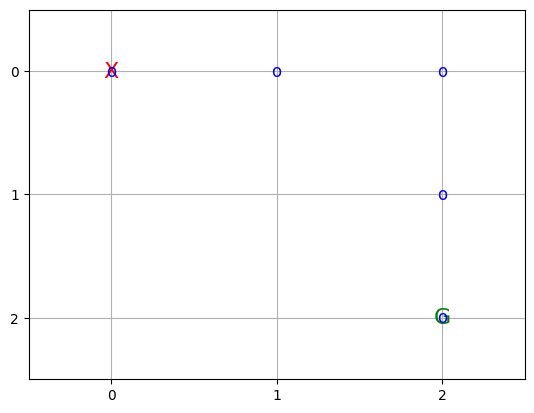

In [5]:
# -------------------------------
# Inference: Visualize the path using the trained Q-table.
def infer_path(Q, env):
    # Start from the initial state.
    state = env.start
    path = [state]
    # Prevent infinite loops in case of poor Q-values.
    max_steps = env.size * env.size * 2
    steps = 0
    while state != env.goal and steps < max_steps:
        s_index = state_to_index(state, env.size)
        a = int(np.argmax(Q[s_index]))
        row, col = state
        if a == 0:
            next_state = (max(row - 1, 0), col)
        elif a == 1:
            next_state = (min(row + 1, env.size - 1), col)
        elif a == 2:
            next_state = (row, max(col - 1, 0))
        elif a == 3:
            next_state = (row, min(col + 1, env.size - 1))
        if next_state == state:  # avoid loops if no movement occurs
            break
        path.append(next_state)
        state = next_state
        steps += 1
    return path

# Code snippet for inference.
print("\nInference demonstration using the trained Q-table:")
env.reset()
inference_path = infer_path(Q, env)
print("Path from start to goal:", inference_path)
plot_maze(env, path=inference_path)